<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/label_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [108]:
onlinedataset=True
if onlinedataset:
  url = "https://drive.google.com/file/d/1TBcW6O9KMRMh9CWf36OIjZwvY-qzH1VS/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  credit_record=pd.read_csv(url,index_col=0)
  url = "https://drive.google.com/file/d/1Ktdv2NTyK2AM48yBvbpFezd82-srqj7w/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  cleaned_app_df=pd.read_csv(url,index_col=0)
else:
  pathtodataset="./content/application.csv"
  credit_record=pd.read_csv(pathtodataset,index_col=0)
  pathtoapp="./content/cleaned_application.csv"
  cleaned_app_df=pd.read_csv(pathtoapp,index_col=0)

In [109]:
credit_record

,id,month_bal,status
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [110]:
credit_record["month_bal"].unique(),credit_record["status"].unique()

(array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
        -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
        -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
        -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
        -52, -53, -54, -55, -56, -57, -58, -59, -60]),
 array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object))

In [111]:
to_avg={"X":-1,"C":0}
for i in range(6):
  to_avg[str(i)]=i+1

In [112]:

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [113]:
credit_record=credit_record.replace({"status":to_avg})

In [114]:
credit_record

,id,month_bal,status
0,5001711,0,-1
1,5001711,-1,1
2,5001711,-2,1
3,5001711,-3,1
4,5001712,0,0
...,...,...,...
1048570,5150487,-25,0
1048571,5150487,-26,0
1048572,5150487,-27,0
1048573,5150487,-28,0


In [115]:
series=credit_record.groupby("id")["status"].mean()

In [116]:
X=np.array(series).reshape(-1,1)

https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [117]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

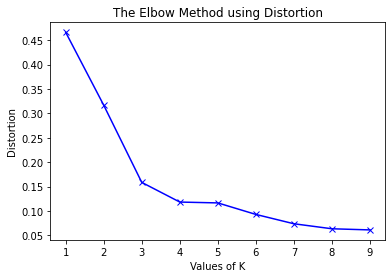

In [118]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

It seems K=4 is the elbow

In [119]:
df=pd.DataFrame(series)
label1=df.copy()

We repeat Kmeans with 30 random states as 30 already is a statisically large sample size

In [120]:
maxInertia=float("INF")
bestkmeans=None
for i in range(30):
  kmeanModel = KMeans(n_clusters=4,random_state=i).fit(X)
  kmeanModel.fit(X)
  if kmeanModel.inertia_<maxInertia:
    print(f"better clusters found with inertia = {kmeanModel.inertia_} at \n{kmeanModel.cluster_centers_}")
    bestkmeans=kmeanModel
    maxInertia=kmeanModel.inertia_


better clusters found with inertia = 1695.9139047710523 at 
[[ 0.07942569]
 [ 0.97565929]
 [-0.91648491]
 [ 0.49356766]]
better clusters found with inertia = 1695.459437499488 at 
[[ 0.07233007]
 [ 0.97330256]
 [-0.91823825]
 [ 0.48310344]]
better clusters found with inertia = 1695.3844909516647 at 
[[ 0.9734455 ]
 [ 0.07469211]
 [-0.91792067]
 [ 0.48606976]]
better clusters found with inertia = 1695.3844289459207 at 
[[ 0.07411095]
 [ 0.48523226]
 [-0.91792067]
 [ 0.97334345]]


In [121]:
label1["label"]=bestkmeans.labels_

In [122]:
bestkmeans.cluster_centers_

array([[ 0.07411095],
       [ 0.48523226],
       [-0.91792067],
       [ 0.97334345]])

Cluster 0 is neutral, cluster 1 is bad, cluster 2 is good and cluster 3 is very bad. We can compress the groups into 2 classes later as we would be losing information if we compress them before we add into our neural network/logistic regression

In [123]:
label_dict={0:"neutral",1:"bad",2:"good",3:"very bad"}

In [124]:
out=label1.drop(columns=["status"]).replace({"label":label_dict})

In [125]:
out.to_csv("average_label.csv")

We can also try kmeans on the exponential moving average!

In [126]:
descDf=credit_record.sort_values(['id','month_bal'],ascending=[True,True])

In [127]:
descDf

,id,month_bal,status
3,5001711,-3,1
2,5001711,-2,1
1,5001711,-1,1
0,5001711,0,-1
22,5001712,-18,1
...,...,...,...
1048549,5150487,-4,0
1048548,5150487,-3,0
1048547,5150487,-2,0
1048546,5150487,-1,0


We set alpha = 1/60 as the max length of the credit record is 60 and pandas will deal with all the lengths < 60 for us

In [128]:
eMovingAvg=descDf.groupby("id")["status"].ewm(alpha=0.017).mean()

In [129]:
clustering2=eMovingAvg.groupby("id").nth([-1])

Find k clusters using elbow method

In [130]:
clustering2

id
5001711    0.487068
5001712    0.485680
5001713   -1.000000
5001714   -1.000000
5001715   -1.000000
             ...   
5150482    0.631848
5150483   -1.000000
5150484    0.914917
5150485    1.000000
5150487    0.000000
Name: status, Length: 45985, dtype: float64

In [131]:
Xevm=np.array(clustering2).reshape(-1, 1)

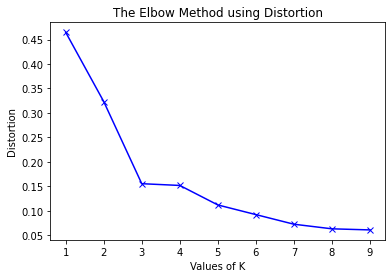

In [132]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(Xevm)
    kmeanModel.fit(Xevm)
  
    distortions.append(sum(np.min(cdist(Xevm, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / Xevm.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(Xevm, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / Xevm.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Seems we choose k=3 here!

In [133]:
max2Inertia=float("INF")
best2kmeans=None
for i in range(30):
  kmeanModel = KMeans(n_clusters=3,random_state=i).fit(Xevm)
  kmeanModel.fit(Xevm)
  if kmeanModel.inertia_<max2Inertia:
    print(f"better clusters found with inertia = {kmeanModel.inertia_} at \n{kmeanModel.cluster_centers_}")
    best2kmeans=kmeanModel
    max2Inertia=kmeanModel.inertia_


better clusters found with inertia = 2446.5718854005663 at 
[[ 0.8860665 ]
 [ 0.17059367]
 [-0.90456218]]
better clusters found with inertia = 2446.5652322584665 at 
[[ 0.17032936]
 [ 0.88604403]
 [-0.90549149]]
better clusters found with inertia = 2446.5563394694195 at 
[[ 0.16998196]
 [-0.90532265]
 [ 0.88545993]]


In [134]:
label2["label"]=best2kmeans.labels_

In [135]:
best2kmeans.cluster_centers_

array([[ 0.16998196],
       [-0.90532265],
       [ 0.88545993]])

In [136]:
label_dict2={0:"neutral",1:"good",2:"bad"}

In [137]:
out2=label2.drop(columns=["status"]).replace({"label":label_dict2})

In [138]:
out2.to_csv("expo_moving_labels.csv")